In [216]:
import numpy as np
import matplotlib.pyplot as plt
import qutip
import seaborn
import random
import math
%matplotlib inline

In [615]:
def hs1Delta(t,args):
    """
    Frequency Scanned
    args:[T,Delta0,Detuning,Omega0,noise0,noise1,steps,freq1]
    """
    Delta = 1.0 * args[1] * np.tanh(2 *1.6* np.pi * (t/args[0]-0.5))+args[2]
    #print(type(Delta))
    return Delta

def hs1Omega(t,args):
    """
    Rabi Frequency Scanned
    args:[T,Delta0,Detuning,Omega0,noise0,noise1]
    """
    Omega = 1.0 * args[3] / np.cosh(2 *1.6* np.pi * (t/args[0]-0.5))
    return Omega


0.999994423418
CPU times: user 429 ms, sys: 43.4 ms, total: 472 ms
Wall time: 472 ms


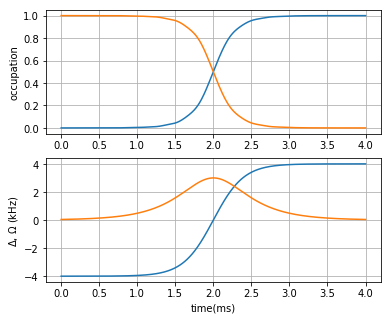

In [637]:
%%time
H=[[(qutip.sigmap()+qutip.sigmam())/2,hs1Omega],[-qutip.sigmap()*qutip.sigmam(),hs1Delta]]
#H=[[(qutip.sigmay())/2,hs1Omega],[-qutip.sigmaz()/2,hs1Delta]]

T=0.004
Delta0=4000.0*2*np.pi
Detuning=0*2100*2*np.pi
Omega0=3000.0*2*np.pi
noise0=1500*2*np.pi
noise1=1000*2*np.pi
steps=1000
freq1=19200
args=[T,Delta0,Detuning,Omega0,noise0,noise1,steps,freq1]

tlist=np.linspace(0,T,500)
expectoper=[qutip.ket2dm(qutip.basis(2,0)),qutip.ket2dm(qutip.basis(2,1))]
s=qutip.mesolve(H, qutip.basis(2,1), tlist, [],
                expectoper,args=args,options=qutip.Options(nsteps=50000))
print(s.expect[0][-1])
fig,ax=plt.subplots(2,1,figsize=(6,5))
ax[0].grid(True)
ax[0].set_ylabel('occupation')
ax[1].set_ylabel('$\Delta$, $\Omega$ (kHz)')
ax[1].set_xlabel('time(ms)')
ax[1].grid(True)
ax[0].plot(tlist*1000,s.expect[0],tlist*1000,s.expect[1])
ax[1].plot(tlist*1000,hs1Delta(tlist,args)/(2*np.pi*1000),tlist*1000,hs1Omega(tlist,args)/(2*1000*np.pi))

CPU times: user 34.1 s, sys: 499 ms, total: 34.6 s
Wall time: 36 s


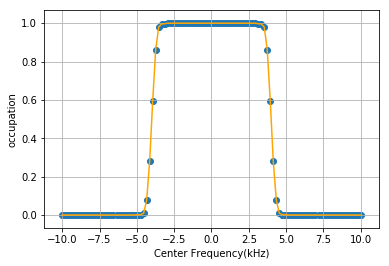

In [638]:
%%time

centerstep=np.linspace(-10*1000*2*np.pi,10*1000*2*np.pi,100)
occlist=[]
for center in centerstep:
    args[2]=center
    occ=qutip.mesolve(H, qutip.basis(2,1), tlist, [], expectoper,args=args).expect[0][-1]
    occlist.append(occ)

occlist0=occlist
plt.grid(True)   
plt.ylabel('occupation')
plt.xlabel('Center Frequency(kHz)')
plt.plot(centerstep/(2*1000*np.pi),occlist,'orange')
plt.scatter(centerstep/(2*1000*np.pi),occlist)

occupation of the desired state:  0.792395689271
CPU times: user 3.22 s, sys: 70.6 ms, total: 3.29 s
Wall time: 3.53 s


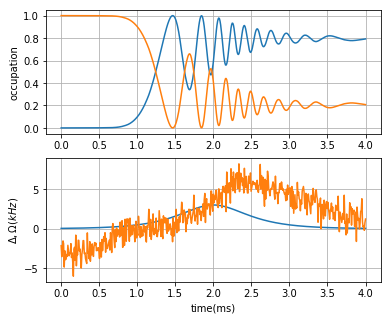

In [647]:
%%time
T=0.004
Delta0=4000.0*2*np.pi
Detuning=0*2100*2*np.pi
Omega0=3000.0*2*np.pi
noise0=0.5*2100*2*np.pi
noise1=2*2100*2*np.pi
steps=500
freq1=1000
args=[T,Delta0,Detuning,Omega0,noise0,noise1,steps,freq1]

def getocc(args):
    tlist=np.linspace(0,args[0],args[6]+1)
    np.random.seed(0)
    H1=hs1Omega(tlist,args)
    H2=hs1Delta(tlist,args)+args[4]*np.random.randn(args[6]+1)+args[5]*np.sin(args[7]*tlist)
    H=[H1[i]*(qutip.sigmap()+qutip.sigmam())/2
       -H2[i]*qutip.sigmap()*qutip.sigmam() for i in range(args[6])] 

    occlist=[[0,1]]
    tgap=args[0]/args[6]
    tmps=qutip.mesolve(H[0], qutip.basis(2,1), [0,tgap], [],args=args)
    occlist.append([qutip.expect(qutip.ket2dm(qutip.basis(2,0)),tmps.states[1]),
                    qutip.expect(qutip.ket2dm(qutip.basis(2,1)),tmps.states[1])])
    for h in H[1:]:
        tmps=qutip.mesolve(h, tmps.states[1], [0,tgap], [],args=args)
        occlist.append([qutip.expect(qutip.ket2dm(qutip.basis(2,0)),tmps.states[1]),
                        qutip.expect(qutip.ket2dm(qutip.basis(2,1)),tmps.states[1])])

    occlist=np.array(occlist)
    return occlist,H1,H2,tlist

occlist,H1,H2,tlist=getocc(args)
print('occupation of the desired state: ',occlist[-1][0])
fig,ax=plt.subplots(2,1,figsize=(6,5))
ax[0].grid(True)
ax[1].grid(True)
ax[0].set_ylabel('occupation')
ax[1].set_xlabel('time(ms)')
ax[1].set_ylabel('$\Delta,\Omega(kHz)$')
ax[0].plot(tlist*1000,occlist[:,0],tlist*1000,occlist[:,1])
ax[1].plot(tlist*1000,H1/(2*1000*np.pi),tlist*1000,H2/(2*1000*np.pi))

In [648]:
%%time
def getdet(detuning,args):
    args=args.copy()
    occdetlist=[]
    for detun in detuning:
        args[2]=detun
        occlist,_,_,_=getocc(args)
        occdetlist.append(occlist[-1][0])
    return occdetlist

detuning=np.linspace(-10*1000*2*np.pi,10*1000*2*np.pi,100)
occdetlist=getdet(detuning,args)

CPU times: user 3min 16s, sys: 1.62 s, total: 3min 18s
Wall time: 3min 22s


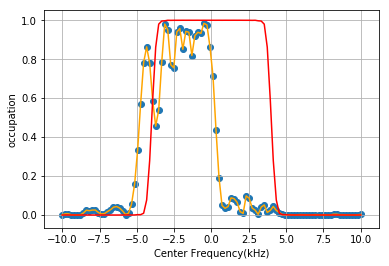

In [649]:
plt.grid(True)
plt.ylabel('occupation')
plt.xlabel('Center Frequency(kHz)')
plt.plot(detuning/(2*np.pi*1000),occdetlist,'orange')
plt.scatter(detuning/(2*np.pi*1000),occdetlist)
plt.plot(centerstep/(2*1000*np.pi),occlist0,'r')

In [590]:
#H1=[1000*2*np.pi]*len(tlist)
H1=hs1Omega(tlist,args)
H2=hs1Delta(tlist,args)+args[4]*np.random.randn(args[6]+1)+args[5]*np.sin(args[7]*tlist)
H=[H1[i]*(qutip.sigmap()+qutip.sigmam())/2
    -H2[i]*qutip.sigmap()*qutip.sigmam() for i in range(args[6])] 

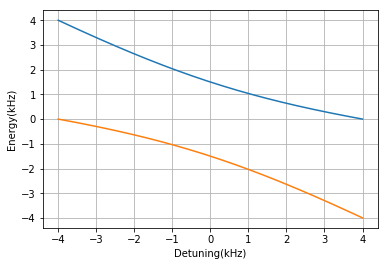

In [610]:
energyhigh=[]
energylow=[]

for i in range(len(H)):
    energyhigh.append(np.max(H[i].eigenstates()[0])/(2*np.pi*1000))
    energylow.append(np.min(H[i].eigenstates()[0])/(2*np.pi*1000))

#plt.plot(tlist,H2)
plt.grid(True)
plt.xlabel('Detuning(kHz)')
plt.ylabel('Energy(kHz)')
plt.plot(H2[:-1]/(2*np.pi*1000),energyhigh)
plt.plot(H2[:-1]/(2*np.pi*1000),energylow)